In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import hamiltonian_monte_carlo as hmc
import diagnostics
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import pickle

import pystan
import stan_utility

## Compile the Stan model

In [32]:
model = stan_utility.compile_model('toy_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_478b0f2c298344b782e4d0e652621517 NOW.


In [33]:
fit = model.sampling(seed=33, verbose=True)

In [34]:
fit

Inference for Stan model: anon_model_478b0f2c298344b782e4d0e652621517.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]  -2.12  9.7e-3   0.51  -3.13  -2.46  -2.11  -1.78  -1.11   2746    1.0
theta[1]  -5.35    0.01   0.51  -6.36   -5.7  -5.36   -5.0  -4.37   2307    1.0
lp__     -418.7    0.02    1.0 -421.5 -419.1 -418.4 -418.0 -417.7   1754    1.0

Samples were drawn using NUTS at Thu Oct 18 16:05:01 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [35]:
stan_utility.check_treedepth(fit)
stan_utility.check_energy(fit)
stan_utility.check_div(fit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 4000 iterations ended with a divergence (0.0%)


In [36]:
sampler_params = fit.get_sampler_params(inc_warmup=False)

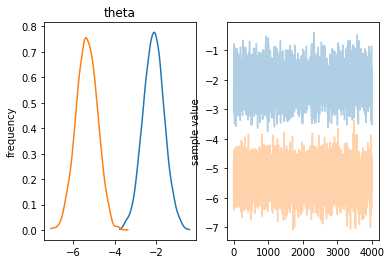

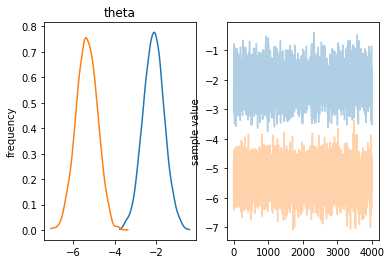

In [37]:
fit.plot()

In [38]:
samples_by_chain = np.reshape(fit['theta'], (4, 1000, 2))

In [51]:
def two_d_mixture_gaussians(theta):
    return hmc.np.log(0.5 * hmc.stats.multivariate_normal.pdf(theta, mean=hmc.np.array([2, 12]),
                                                          cov=hmc.np.array(([[2, 0.5], [0.5, 1]]))) + \
                  0.25 * hmc.stats.multivariate_normal.pdf(theta, mean=hmc.np.array([10, -8]),
                                                           cov=hmc.np.array(([[1, 0.9], [0.9, 2]]))) + \
                  0.25 * hmc.stats.multivariate_normal.pdf(theta, mean=hmc.np.array([-12, -9]),
                                                           cov=hmc.np.array(([[0.5, 0], [0, 0.5]]))))

DEFAULT_COLORMAP = 'Paired'


def two_d_countour_plot(log_density, num_chains, first_param_limits, second_param_limits,
                        samples, suptitle='', colormap_name=DEFAULT_COLORMAP):
    theta_one_values = np.linspace(first_param_limits[0], first_param_limits[1], 100)
    theta_two_values = np.linspace(second_param_limits[0], second_param_limits[1], 100)
    
    theta_one_grid, theta_two_grid = np.meshgrid(theta_one_values, theta_two_values)
    theta_grid = np.stack((theta_one_grid, theta_two_grid), axis=2)
    contour_values = log_density(theta_grid)
        
    colormap = plt.get_cmap(colormap_name)
    plt.figure(figsize=(12, 12))
    plt.contour(theta_one_grid, theta_two_grid, contour_values, 30)
    
    for i in range(num_chains):
        plt.scatter(samples[i, : , 0], samples[i, : , 1], 
                    c=colormap.colors[2 * i], label=f'Chain #{i+1}')
        
    legend = plt.legend(loc='best')
    for i in range(num_chains):
        legend.legendHandles[i].set_color(colormap.colors[(2 * i) + 1])
        
    ess = diagnostics.effective_sample_size(samples)
    rhat = diagnostics.split_r_hat(samples)
    
    with np.printoptions(precision=5, suppress=True):
        plt.title(f'Sampling results, ESS = {ess}, $\\hat{{R}}$ = {rhat}')
    
    plt.suptitle(suptitle, size=20, y=0.93)
    
    plt.show()

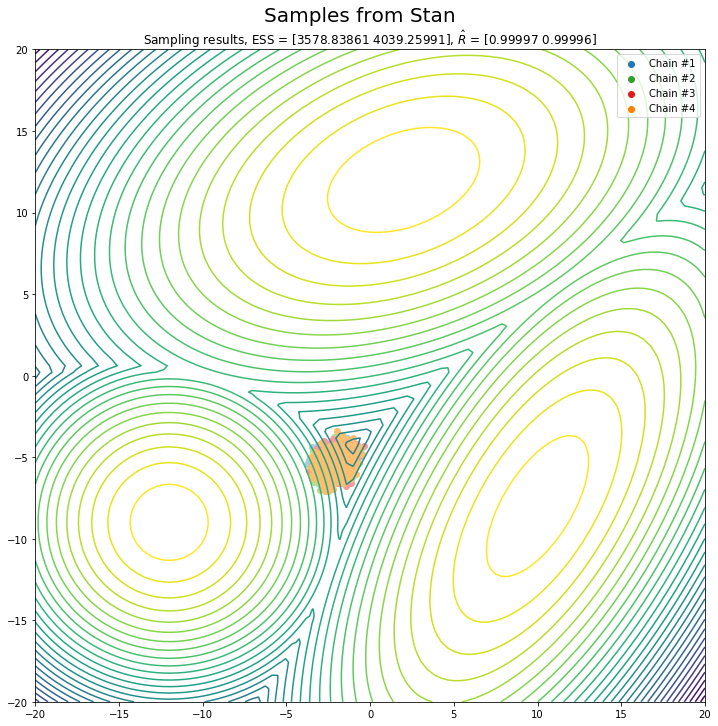

In [52]:
two_d_countour_plot(two_d_mixture_gaussians, 4, [-20, 20], [-20, 20], samples_by_chain,
                   r'Samples from Stan')

OrderedDict([('summary',
              array([[-2.11711603e+00,  9.72237182e-03,  5.09474548e-01,
                      -3.12719066e+00, -2.46111794e+00, -2.11332310e+00,
                      -1.78320167e+00, -1.10603988e+00,  2.74600000e+03,
                       1.00107417e+00],
                     [-5.35437104e+00,  1.06545092e-02,  5.11749287e-01,
                      -6.35893954e+00, -5.70391838e+00, -5.35548483e+00,
                      -4.99846821e+00, -4.36608302e+00,  2.30700000e+03,
                       1.00189990e+00],
                     [-4.18743160e+02,  2.38997054e-02,  1.00093838e+00,
                      -4.21559488e+02, -4.19142603e+02, -4.18421716e+02,
                      -4.18023830e+02, -4.17755616e+02,  1.75400000e+03,
                       1.00078726e+00]])),
             ('c_summary',
              array([[[  -2.12280671,    0.52224513,   -2.13781309,    0.51235545],
                      [  -2.10435527,    0.5029917 ,   -2.10348904,    0.49997791],


array([2.08653032, 1.93458503])